# Problem: Loading 4D variables and writing output to zarr
use kerchunk, concat and merge, then rechunk.
we observe some missing values from some time dimensions.

In [ ]:
pip install xmip

## Import packages

In [1]:
import numpy as np
import xarray as xr
import dask
import s3fs
import zarr
import warnings
import xmip.preprocessing as xmip
warnings.filterwarnings('ignore')

## Create a new Dask cluster with the Dask Gateway

In [2]:
from dask_gateway import Gateway
gateway = Gateway()

In [3]:
##A line of trick to clean your dask cluster before you start your computation
from dask.distributed import Client
clusters=gateway.list_clusters()
print(clusters )
for cluster in clusters :
    cluster= gateway.connect(cluster.name)
    print(cluster)
    client = Client(cluster)
    client.close()
    cluster.shutdown()

[ClusterReport<name=daskhub.fc3e1625206c4f008b7aea362af606ab, status=RUNNING>]
GatewayCluster<daskhub.fc3e1625206c4f008b7aea362af606ab, status=running>


In [4]:
cluster = gateway.new_cluster(worker_memory=8, worker_cores=2)

cluster.scale(1)
cluster

## Get a client from the Dask Gateway Cluster

As stated above, creating a Dask `Client` is mandatory in order to perform following Daks computations on your Dask Cluster.

In [5]:
from distributed import Client

if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.d2602264ef4b4245a62e4ccbb609e96d/status,


## Install xmip to dask client ( you'll need to do this each time you start dask, if your dask client use xmip)

In [6]:
from distributed.diagnostics.plugin import PipInstall
extra_packages=['xmip']
plugin=PipInstall(extra_packages,restart=True)


In [8]:
client.register_worker_plugin(plugin)

{'tls://10.244.26.236:43105': {'status': 'OK'},
 'tls://10.244.27.213:38453': {'status': 'OK'},
 'tls://10.244.30.235:33709': {'status': 'OK'},
 'tls://10.244.33.244:41003': {'status': 'OK'}}

## Open dictionary of OMIP2 simulations
With file lists taken from the ESGF Search Catalog with the following search requirements:
1. On the native grid
2. Have the varaibles:`umo`, `vmo`, `so`, `thetao`, `zos`, `mlotst`, `siconc`, `deptho`, `areacello`
3. At monthly time steps
4. The last 61 years of the simulation

In [9]:
# Load in file of model names and fnames
model_fnames_dict = np.load("models.npy", allow_pickle=True).item()


## Function for writing zarr file to bucket

In [10]:
def write_dataset_to_zarr(ds,sim_name):
    import zarr
    compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)

    # set path on bucket
    path='WAFFLES/OMIP2_k'
    s3_prefix = "s3://" + path
    print(s3_prefix)
    
    # get storage keys
    access_key = !aws configure get aws_access_key_id
    access_key = access_key[0]
    secret_key = !aws configure get aws_secret_access_key
    secret_key = secret_key[0]
    
    # set storage target
    client_kwargs = {'endpoint_url': 'https://object-store.cloud.muni.cz'}
    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs)
    
    # make file name for variable in simulation
    zarr_file_name = sim_name
    uri = f"{s3_prefix}/{zarr_file_name}"
    print('saving zarr file at '+ uri)
    
    # get store argument for zarr
    store = zarr.storage.FSStore(uri,client_kwargs=client_kwargs,
                                 key=access_key, secret=secret_key)
    # set encodings
    
    #,encoding={"foo": {"compressor": compressor}}
    
    # write variable to zarr
    
    
    %time ds.to_zarr(store=store,mode='w',consolidated=True)
    
    return

## Function for reading from zarr bucket

In [11]:
def read_dataset_from_zarr(sim_name):
    # set path on bucket
    path='WAFFLES/OMIP2_k'
    s3_prefix = "s3://" + path
    print(s3_prefix)
    
    # get storage keys
    access_key = !aws configure get aws_access_key_id
    access_key = access_key[0]
    secret_key = !aws configure get aws_secret_access_key
    secret_key = secret_key[0]
    
    # set storage target
    client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'}
    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs)
    
    # file name for simulation
    zarr_file_name = sim_name
    uri = f"{s3_prefix}/{zarr_file_name}"
    print('loading zarr file from '+uri)
    
    # get store argument for zarr
    store = zarr.storage.FSStore(uri,client_kwargs=client_kwargs,
                                 key=access_key, secret=secret_key)
    
    # read variable from zarr
    ds=xr.open_zarr(store=store)
    
    return ds

## Using kerchunk for loading CMIP6 files.
### Function for transforming each http path of NetCDF file into Kerchunk, and save them in S3 bucket.  


### Run the transformation using dask but, one model by one model since the server is not stable...
See the working notebook 'Create_kerchunk_fromlist.ipynb

### Verifying how many models that Waffle need from CMPI6 server

In [12]:
for a in model_fnames_dict.keys():
    print(len(model_fnames_dict.get(a)),a)

368 EC-Earth3
44 NorESM2-LM
8 MRI-ESM2-0
8 CMCC-CM2-SR5
107 CNRM-CM6-1
8 FGOALS-f3-L
28 CMCC-CM2-HR4
34 MIROC6
8 TaiESM1-TIMCOM2
107 CNRM-CM6-1-HR
260 ACCESS-OM2-025
260 ACCESS-OM2
8 TaiESM1-TIMCOM


### List the transformed kerchunk files

In [13]:
#setting for accessing s3

# get storage keys
access_key = !aws configure get aws_access_key_id
access_key = access_key[0]
secret_key = !aws configure get aws_secret_access_key
secret_key = secret_key[0]

# set storage target
client_kwargs = {'endpoint_url': 'https://object-store.cloud.muni.cz'}

def dict_kerchunk(client_kwargs,access_key,secret_key):
    import kerchunk.hdf
    import fsspec

    path='WAFFLES/kerchunk/'
    #path='tmp/kerchunk/'


    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs,key=access_key,secret=secret_key)
    modelnames=target.ls(path)
    modelnames=[name.rsplit('/')[-1] for name in modelnames]
    d={}
    for name in modelnames :
        d[name]=target.ls(path+name)
        d[name]=['s3://'+n for n in d[name]]
#        print(path+name)
    return d
d=dict_kerchunk(client_kwargs,access_key,secret_key)


for a in model_fnames_dict.keys():
    computed=len(d.get(a)) if (a in d) else 'None'
    print(a, len(model_fnames_dict.get(a)), 'transformed done' ,computed)

EC-Earth3 368 transformed done 368
NorESM2-LM 44 transformed done 44
MRI-ESM2-0 8 transformed done None
CMCC-CM2-SR5 8 transformed done 8
CNRM-CM6-1 107 transformed done 107
FGOALS-f3-L 8 transformed done None
CMCC-CM2-HR4 28 transformed done 28
MIROC6 34 transformed done 1
TaiESM1-TIMCOM2 8 transformed done 8
CNRM-CM6-1-HR 107 transformed done 107
ACCESS-OM2-025 260 transformed done 260
ACCESS-OM2 260 transformed done 260
TaiESM1-TIMCOM 8 transformed done 8


### Preprocessing and options for loading CMIP6 data throught kerchunk

In [14]:
target_options={
            "anon":False,
            "client_kwargs":client_kwargs,
            "key":access_key, 
            "secret":secret_key}

def model_preproc_new(ds):
    return (
        ds.drop_vars(["bnds", "vertex"], errors="ignore")
        #fix naming 
        .pipe(xmip.rename_cmip6)
        # reindex y if lat is decreasing
        .pipe(reindex_lat)
        # promote empty dims to actual coordinates
        .pipe(xmip.promote_empty_dims)
        # demote coordinates from data_variables
        .pipe(xmip.correct_coordinates)
        # broadcast lon/lat
        .pipe(xmip.broadcast_lonlat)
        # shift all lons to consistent 0-360
        .pipe(xmip.correct_lon)
        # fix the units
        .pipe(xmip.correct_units)
        # rename the `bounds` according to their style (bound or vertex)
        .pipe(xmip.parse_lon_lat_bounds)
        # sort verticies in a consistent manner
        .pipe(xmip.sort_vertex_order)
        # convert vertex into bounds and vice versa, so both are available
        .pipe(xmip.maybe_convert_bounds_to_vertex)
        .pipe(xmip.maybe_convert_vertex_to_bounds)
        .pipe(xmip.fix_metadata)
        #.drop_vars(["bnds", "vertex"], errors="ignore")
        )
def reindex_lat(ds):
    # check if lat is decreasing
    if ds.lat.isel(x=0,y=0) > 0:
        ds = ds.reindex(y=list(reversed(ds.y))).assign_coords(y=ds.y)    
    return ds 

### Function to load CMIP6 data from kerchunk

In [15]:
def cmip6_kerchunk(model,variables,model_fnames_dict):
    ## Generate filename from model_fnames_dict
    fnames_i = model_fnames_dict[model]
    #print(fnames_i.replace('dodsC','fileServer'))

    print(fnames_i)
    dss = {}
    print('Going through the variables...')
    raw_names={
        v: [f for f in fnames_i if v+'_' in f]
        for v in variables
    }

    names={key: value for key,value in raw_names.items() if value }

    dss={var: [xr.open_dataset(
                        "reference://", engine="zarr",
                        backend_kwargs={
                            "storage_options": {
                                "fo":f,
                                "target_options":target_options
                            },
                            "consolidated": False
                        } ,chunks={'lev':-1}                    
                    ).pipe(model_preproc_new)
               for f in urls] for var, urls in names.items()}
    dss_concat = {
        var: xr.concat(values,dim='time',coords='minimal',data_vars='minimal',compat='override') 
        for var, values in dss.items()}


    chunks={'time':-1,'lev':-1,'x':25,'y':25}

    dsnow = (
        xr.merge([ds.chunk({name: chunksize for name, chunksize in chunks.items() if name in ds.dims}) for ds in dss_concat.values()], compat='override')
        .assign_coords(lat= lambda ds : ds.lat.compute(),lon= lambda ds : ds.lon.compute())
        .where(lambda ds: ds['lat']>=50 ,drop=True)
        )
    return dsnow    

### Load model to xarray dataset

In [16]:
model = 'CMCC-CM2-SR5'
variables = ['umo', 'vmo', 'so', 'thetao']#, 'zos', 'mlotst', 'siconc', 'deptho', 'areacello']
model_fnames_dict=d
dsnow= cmip6_kerchunk(model,variables,model_fnames_dict)



['s3://WAFFLES/kerchunk/CMCC-CM2-SR5/areacello_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.json', 's3://WAFFLES/kerchunk/CMCC-CM2-SR5/deptho_Ofx_CMCC-CM2-SR5_omip1_r1i1p1f1_gn.json', 's3://WAFFLES/kerchunk/CMCC-CM2-SR5/mlotst_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_165301-201812.json', 's3://WAFFLES/kerchunk/CMCC-CM2-SR5/so_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.json', 's3://WAFFLES/kerchunk/CMCC-CM2-SR5/thetao_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.json', 's3://WAFFLES/kerchunk/CMCC-CM2-SR5/umo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.json', 's3://WAFFLES/kerchunk/CMCC-CM2-SR5/vmo_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.json', 's3://WAFFLES/kerchunk/CMCC-CM2-SR5/zos_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_165301-201812.json']
Going through the variables...


In [17]:
sim_name='tinatest1.zarr'


In [18]:
target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs,key=access_key,secret=secret_key)
target.ls('WAFFLES/OMIP2_k/tinatest1.zarr')
#target.rm('WAFFLES/tinaok',recursive=True)

['WAFFLES/OMIP2_k/tinatest1.zarr/.zattrs',
 'WAFFLES/OMIP2_k/tinatest1.zarr/.zgroup',
 'WAFFLES/OMIP2_k/tinatest1.zarr/so']

In [107]:
dstest=dsnow.copy()
dstest=dstest.persist()

## Some values in time dimension are mising!

In [108]:
#dstest.thetao.max(dim=["y","x"]).plot(x='time',y='lev',robust=True)
#dstest.thetao.mean(dim=["lev"],skipna=True).sel(time='2000-09')#.plot(x='lat',y='lon',robust=True)
#dstest.thetao.sel(time='2000-03').isel(lev=1).plot(x='lat',y='lon',robust=True)
import hvplot
import hvplot.xarray
dstest.thetao.sel(time='2000-03').isel(lev=1).hvplot.quadmesh(x='lat',y='lon')
dstest.thetao.count(dim=["y","x"]).hvplot(x='time')#.quadmesh(x='lat',y='lon')

:DynamicMap   [lev]
   :Curve   [time]   (thetao)

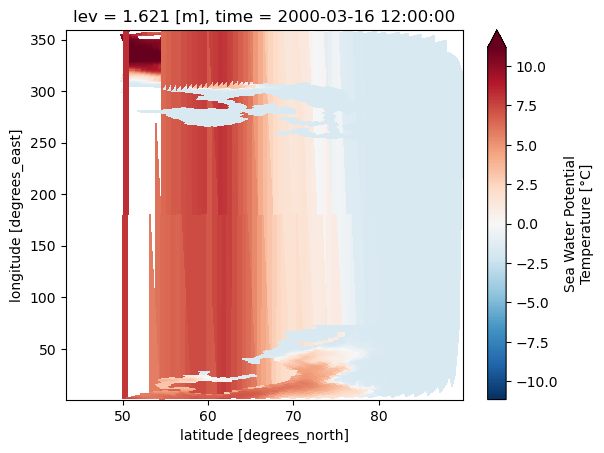

In [109]:
dstest.thetao.sel(time='2000-03').isel(lev=1).plot(x='lat',y='lon',robust=True)

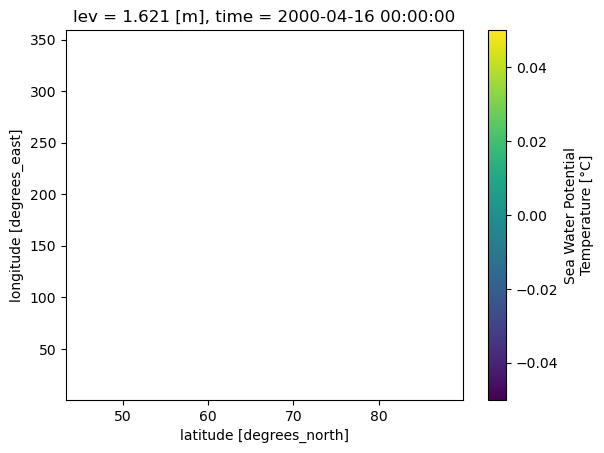

In [110]:
dstest.thetao.sel(time='2000-04').isel(lev=1).plot(x='lat',y='lon',robust=True)

In [118]:
#Do you need lat_verticies??
dstest=dstest.drop_vars(["lat_verticies", "lon_verticies"], errors="ignore")
# with where , drop=True, some values are gone, thus we need to re-chunk to have 'zarr' acceptable chunk shape
chunks={'time':-1,'lev':-1,'x':25,'y':25,'vertex':-1,'bnds':-1}
dstest=dstest.chunk(chunks)



In [115]:
dstest

<xarray.Dataset>
Dimensions:        (time: 732, lev: 50, y: 72, x: 359, bnds: 2, vertex: 4)
Coordinates: (12/14)
  * x              (x) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0
  * y              (y) float64 219.0 220.0 221.0 222.0 ... 288.0 289.0 290.0
    lat            (y, x) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
  * lev            (lev) float64 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(25, 25), meta=np.ndarray>
    ...             ...
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(25, 25, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(25, 25, 4), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(2, 25, 25), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(2, 25, 25), meta=np.ndarray>
Data variables:
    umo            (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 25, 25), meta=np.ndarray>
    vmo            (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 25, 25), meta=np.ndarray>
    so             (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 25, 25), meta=np.ndarray>
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(732, 50, 25, 25), meta=np.ndarray>
Attributes: (12/38)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           OMIP
    cmor_version:          3.5.0
    comment:               Ocean initial conditions: WOA 2013 T & S; ocean at...
    contact:               Pier Giuseppe Fogli (piergiuseppe.fogli@cmcc.it)
    creation_date:         2020-02-19T13:19:49Z
    ...                    ...
    table_id:              Omon
    table_info:            Creation Date:(15 January 2020) MD5:bc48740ff90dcf...
    title:                 CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:           hdl:21.14100/66823ef1-74ec-4ff3-a897-a866bce2bdd2
    variable_id:           umo
    variant_label:         r1i1p1f1

In [120]:
write_dataset_to_zarr(dstest,'tinatest1.zarr')

s3://WAFFLES/OMIP2_k
saving zarr file at s3://WAFFLES/OMIP2_k/tinatest1.zarr
CPU times: user 8.33 s, sys: 1.35 s, total: 9.69 s
Wall time: 5min 18s


In [121]:
test=read_dataset_from_zarr(sim_name)

s3://WAFFLES/OMIP2_k
loading zarr file from s3://WAFFLES/OMIP2_k/tinatest1.zarr


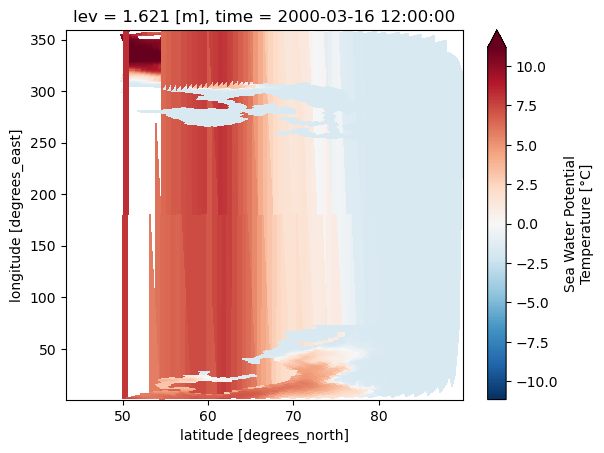

In [122]:
test.thetao.sel(time='2000-03').isel(lev=1).plot(x='lat',y='lon',robust=True)

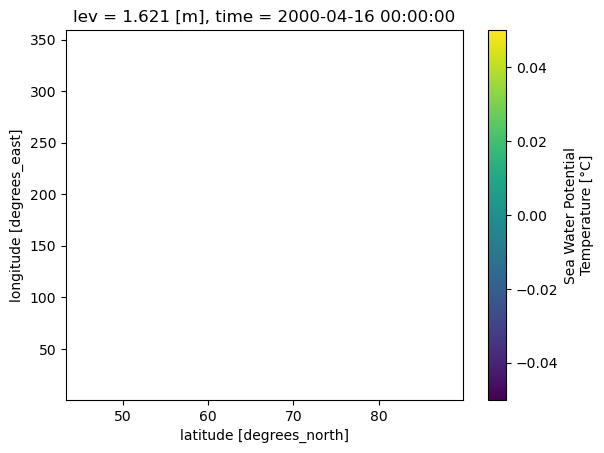

In [123]:
test.thetao.sel(time='2000-04').isel(lev=1).plot(x='lat',y='lon',robust=True)

## Demonstrate loading error
This error is really inconsistent. It fails on different files when I run this and only fails when I'm trying to read in multiple variables at the same time. Also, doesn't always fail...

In [ ]:
sim_name1 = 'CMCC-CM2-SR5'
#variables = ['vmo','thetao','so','umo','zos','mlotst','areacello','deptho']
variables = ['vmo']

In [ ]:
error1#.persist()

In [ ]:
error1.chunk('auto')

In [ ]:
write_dataset_to_zarr(error1,'tinatest1')

## Demonstrate writting error
Basically every model has this problem and this happens when trying to save one of the 4D variables ('vmo','thetao','so','umo') and only happens for some of the models when trying to save 3D variables ('zos','mlotst'). This error basically never happens when saving 2D variables ('areacello','deptho').

In [ ]:
sim_name2 = 'TaiESM1-TIMCOM2'
variables = ['thetao']

In [ ]:
%%time
error2 = ds_from_esgf(sim_name2,model_fnames_dict,variables)

In [ ]:
error2

In [ ]:
write_dataset_to_zarr(error2,sim_name2)

In [ ]:
test = read_dataset_from_zarr(sim_name2)

In [ ]:
test.thetao.isel(time=0,lev=0).plot(robust=True)